# Image classifiers

In [1]:
# Imports to be used through the notebook

import torch 
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time

In [2]:
import torch 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Data (MNIST)

In [3]:
# We define a transformation to apply to the items of the dataset (that are, by default, in PIL image format). The standardization will help with training.

MEAN_MNIST = (0.1307,)
STD_MNIST = (0.3081,)

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_MNIST, STD_MNIST)])


trainset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=True,
                                        download=True, transform=transform_mnist)

testset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=False,
                                       download=True, transform=transform_mnist)


#trainset.__len__() # yields 60000
#trainset.__getitem__(0) # tuple (image, class); image is a tensor 1x28x28 and class is an int
#trainset.__getitem__(0)[0].shape #yields torch.Size([1, 28, 28])

In [4]:
# Trainloaders are dataset wrappers used to access them in a batched way. Of course this is very useful for NN training.
batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("Size train loader: ", len(trainloader), " | test loader: ", len(testloader))

Size train loader:  1875  | test loader:  313


In [5]:
batch = next(iter(trainloader)) # batches are lists of two tensors, one containing features and other labels.

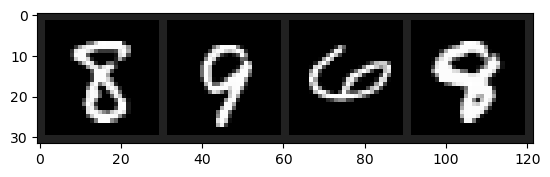

Labels:      8             9             6             8 

Image shape (number of channels, height, width): (1, 28, 28)


In [6]:
# functions to show an image
def imshow(img):
    img = img * STD_MNIST[0] + MEAN_MNIST[0]  # Proper unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # MNIST is grayscale + original tensor shape is (1,28,28) so  np.transpose(img, (1, 2, 0)) gets it to shape (28,28,1) 
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:     ','             '.join(f'{labels[j]}' for j in range(4)), '\n')
print(f'Image shape (number of channels, height, width): {tuple(images[0].shape)}')

## First model
Note that this model outputs logits; not probabilities!

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(1690, output_channels)

    def forward(self, x):
        # Initial shape is [B, 1, 28, 28]
        x = self.conv(x)
        # After convoluting, shape is [B, 10, 26, 26]
        x = nn.ReLU()(x)
        # After ReLU, shape is [B, 10, 26, 26] (it's an element-wise operation)
        x = self.pool(x)
        # After pooling, shape is [B, 10, 13, 13]
        x = nn.Flatten()(x)
        # After flattening shape is [B, 1690] (naturally, 1690 = 10x13x13)
        x = self.fc(x)
        # Final shape is [B, 10] (we have logits for 10 possible classes)
        return x

In [8]:
len(batch[0])

32

### Training 

In [9]:
input_channels=1
output_shape=10
criterion = nn.CrossEntropyLoss()


def build_and_train_model(archi=SimpleCNN, trainloader=trainloader, input_shape=input_channels, output_shape=output_shape, optimizer=optim.SGD, criterion=criterion, device="cpu", n_epochs=10, lr=0.01):
 
  # When building a model, you assign it to a particular device by setting: model = model.to(device); device is indicated by a string, like "cpu" our "cuda:0"
  model = archi(input_shape,output_shape).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (x,y) in enumerate(trainloader):
      # Same as for the model, you have to assign a device for your inputs and your label, for example: x = x.to(device)
      inputs, labels = x.to(device), y.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    print(f'Epoch {epoch} / {n_epochs} | Loss: {running_loss / len(trainloader)}')
    running_loss = 0.0
  return model

In [10]:
start_time = time.time()
model = build_and_train_model(device=device)
print(f"Training with {device} lasts: {np.round((time.time()-start_time)/60,2)} minutes\n")

Epoch 0 / 10 | Loss: 0.16759953777827322
Epoch 1 / 10 | Loss: 0.07413839129395783
Epoch 2 / 10 | Loss: 0.0589734318280903
Epoch 3 / 10 | Loss: 0.05010383976816665
Epoch 4 / 10 | Loss: 0.04324940722764004
Epoch 5 / 10 | Loss: 0.03811072081507882
Epoch 6 / 10 | Loss: 0.0340056354498025
Epoch 7 / 10 | Loss: 0.030555203580272305
Epoch 8 / 10 | Loss: 0.027052442680991953
Epoch 9 / 10 | Loss: 0.02453586785098693
Training with cuda:0 lasts: 1.93 minutes



In [11]:
# Once your model has been trained, you have to evaluate it on the test set.
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in dataloader:
          pred = model(X.to(device))
          loss = loss_fn(pred, y.to(device)).item()
          test_loss += loss
          ### TODO: compute the model final prediction and the number of correct predictions.
          # Your current output is the for each class to be the right one.
          prediction = pred.argmax(axis=1)
          # To compute the accuracy score, we need to know how many correct predictions we got.
          correct += (prediction == y.to(device)).sum().item()
          ###
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [12]:
loss = test_loop(testloader, model, criterion, device)

Test Error: Accuracy: 98.3%, Avg loss: 0.058284 



## Second model with final softmax

In [ ]:
class SimpleCNNprobas(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(1690, output_channels)

    def forward(self, x):
        # Initial shape is [B, 1, 28, 28]
        x = self.conv(x)
        # After convoluting, shape is [B, 10, 26, 26]
        x = nn.ReLU()(x)
        # After ReLU, shape is [B, 10, 26, 26] (it's an element-wise operation)
        x = self.pool(x)
        # After pooling, shape is [B, 10, 13, 13]
        x = nn.Flatten()(x)
        # After flattening shape is [B, 1690] (naturally, 1690 = 10x13x13)
        x = self.fc(x)
        # Final shape is [B, 10] (we have logits for 10 possible classes)
        x = nn.functional.softmax(x, dim=1)   
        # Does not change shape either
        return x

### Training 

In [82]:
input_channels=1
output_shape=10
criterion = nn.KLDivLoss(reduction='batchmean')

model_probas = build_and_train_model(archi=SimpleCNNprobas, criterion=criterion, device=device)

RuntimeError: kl_div: Integral inputs not supported.

In [ ]:
model_probas = build_and_train_model(device=device)

In [ ]:
loss2 = test_loop(testloader, model, criterion, device)

## Example of attack

In [13]:
x_batch, y_batch = next(iter(trainloader)) #x_batch is of dimension [B, C, H, W] = [512, 1, 28, 28]. Elements of it (like x_batch[0]) are of dimension [C, H, W] = [1, 28, 28].
x_single = x_batch[0].unsqueeze(0)  # Add batch dimension back (shape: [1, C, H, W])


x_single = x_single.to(device)
output = model(x_single)

In [14]:
x_batch = x_batch.to(device)

In [37]:
def jacobian_batch(model, x_batch): 
    # Compute jacobian at a point (w.r.t. x only)
    B = len(x_batch) # batch size
    J_all = torch.func.jacrev(model)(x_batch) # yields torch.Size([B, nb_classes, B, C, H, W])
    nb_classes = J_all.shape[1]
    J_diag = J_all.diagonal(dim1=0, dim2=2)   # (B,nb_classes,C,H,W)
    J_diag = J_diag.reshape(B, nb_classes, -1)        # (B,nb_classes,CxHxW)
    return J_diag


10


In [16]:
 # Compute jacobian at a point (w.r.t. x only)
B = len(x_batch) # batch size
J_all = torch.func.jacrev(model)(x_batch) #yields torch.Size([B, 10, B, 1, 28, 28])
print(J_all.shape)
J_diag = J_all.diagonal(dim1=0, dim2=2)   # (10,1,28,28,B)
print(J_diag.shape)
J_diag = J_diag.reshape(B, 10, -1)        # (B,10,784)
print(J_diag.shape)

torch.Size([32, 10, 32, 1, 28, 28])
torch.Size([10, 1, 28, 28, 32])
torch.Size([32, 10, 784])


In [38]:
jacobian_b = jacobian_batch(model, x_single)

In [39]:
J_pinv = torch.linalg.pinv(jacobian_b)

In [40]:
J_pinv.shape

torch.Size([1, 784, 10])

In [41]:
model_output = model(x_batch)

In [42]:
topk = torch.topk(input=model_output, k=3, dim=1)

In [ ]:
def flipping_vector(model, x_batch, attacked_class): 
    model_output = model(x_batch) # [B, c]
    B, c = model_output.shape

    assert 2 <= attacked_class <= c, "attacked_class must be in 2,...,c"

    largest_logits = torch.topk(model_output, k=attacked_class, dim=1).indices

    # i: index of max logit per sample (argmax) -> [B]
    i = largest_logits[:, 0]

    # j: index of attacked_class-th largest logit -> [B]
    j = largest_logits[:, -1] 
    

    flipping = torch.zeros_like(model_output)  # [B, c]

    batch_indices = torch.arange(B) #vector [0, 1, ... , B-1]

    flipping[batch_indices, i] = -1
    flipping[batch_indices, j] = 1

    return flipping 

In [43]:
flips = flipping_vector(model, x_single, 2)

In [44]:
def flat(x):            # x : (B,C,H,W)  contiguous
    return x.reshape(x.size(0), -1)           # (B, C*H*W)

def unflat(v, C, H, W):  # v : (B, C*H*W)
    return v.reshape(v.size(0), C, H, W)      # (B,C,H,W)

In [45]:
print(J_pinv.shape)
print(flips.unsqueeze(2).shape)

torch.Size([1, 784, 10])
torch.Size([1, 10, 1])


In [46]:
attack = torch.bmm(J_pinv, flips.unsqueeze(2))
attack_matrix_batch = unflat(attack.squeeze(2), 1, 28, 28)

In [47]:
x_adversarial = x_single + attack_matrix_batch

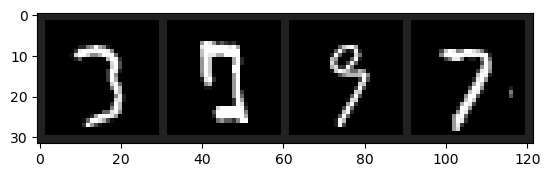

Labels:      3             7             9             7 

Image shape (number of channels, height, width): (1, 28, 28)


In [48]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:     ','             '.join(f'{labels[j]}' for j in range(4)), '\n')
print(f'Image shape (number of channels, height, width): {tuple(images[0].shape)}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


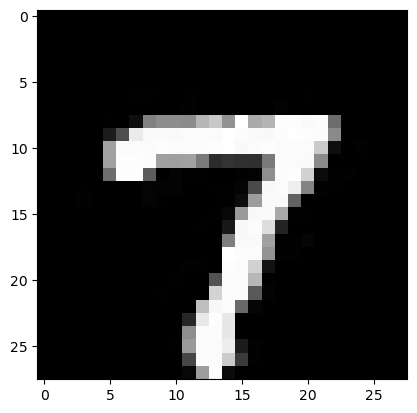

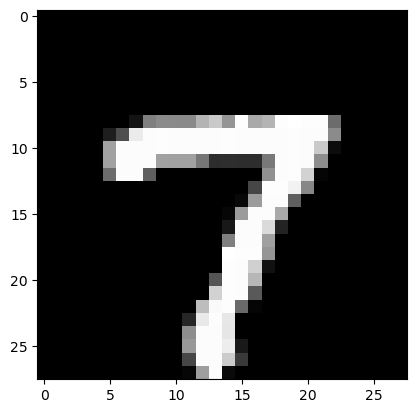

In [30]:
imshow(torchvision.utils.make_grid(x_adversarial.to('cpu')))
imshow(torchvision.utils.make_grid(x_single.to('cpu')))

In [31]:
print(model(x_single))
print(model(x_adversarial))
#This works!!!

tensor([[ -3.8436,   0.8194,  -0.6953,   2.7826,  -3.4599,  -4.4889, -16.2435,
          20.2934,  -3.4680,   6.5621]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -3.8689,   0.8995,  -0.6885,   2.7727,  -3.4356,  -4.4502, -16.2925,
          19.4264,  -3.5797,   7.4543]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


## Attack performance

In [ ]:
def test_loop_attack(dataloader, model, loss_fn, device, attacked_class):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in dataloader:
          pred = model(X.to(device))
          loss = loss_fn(pred, y.to(device)).item()
          test_loss += loss
          # Your current output is the for each class to be the right one.
          prediction = pred.argmax(axis=1)
          # To compute the accuracy score, we need to know how many correct predictions we got.
          correct += (prediction == y.to(device)).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss